# Fixed and smooth effects in location regression

In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import os 

# Set path such that interpreter finds tigerpy
sys.path.append(os.path.join(os.getcwd(), ".."))

import tigerpy.model as tiger
import tigerpy.bbvi as bbvi
from tigerpy.distributions import MultivariateNormalDegenerate

# We use distributions and bijectors from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfjd
import tensorflow_probability.substrates.jax.bijectors as tfjb

rng = np.random.default_rng(42)

# Load the data
df = pd.read_csv('../data/dbbmi.csv', sep=',')

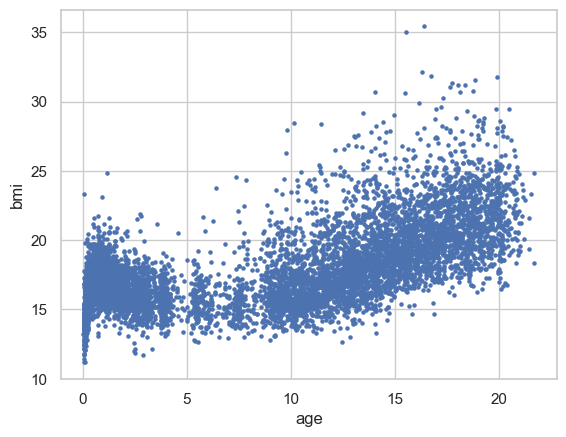

In [2]:
# Plot the data
sns.set_theme(style="whitegrid")
df.plot(kind = "scatter", x = "age", y = "bmi", s = 5)
plt.show()

In [3]:
# Define a model with intercept 
# Set up design matrix 
X = tiger.Obs(name="X_loc", intercept=True)
X.smooth(data=df["age"].to_numpy())
# If we combine fixed covariates and smooth covariates we need to center the the smooth effects first 
X.center()

# Fixed coefficents 
# Set up beta_fixed hyperparameters 
beta_fixed_loc = tiger.Hyper(0.0, name="beta_fixed_loc")
beta_fixed_scale = tiger.Hyper(100.0, name="beta_fixed_scale")

# Set up parameters
beta_fixed_dist = tiger.Dist(tfjd.Normal, loc=beta_fixed_loc, scale=beta_fixed_scale)
beta_fixed = tiger.Param(value=df["bmi"].to_numpy().mean(), distribution=beta_fixed_dist, name="beta_fixed")

# Smooth coefficients
# Set up hyperparameters for the beta_smooth_scale  
tau2_a = tiger.Hyper(1.0, name="tau2_a")
tau2_b = tiger.Hyper(0.00005, name="tau2_b")
tau2_dist = tiger.Dist(tfjd.InverseGamma, concentration=tau2_a, scale=tau2_b)
tau2 = tiger.Param(value=jnp.array([1.0]), distribution=tau2_dist, param_space="positive", name="tau2")

# Smooth coefficients
# Set up smooth coefficients with mvn degenerate 
# Set up hyperparameters
beta_smooth_loc = tiger.Hyper(np.zeros(X.smooth_dim_cent[0]), name="beta_smooth_loc")

# Define the penalty matrix 
pen = tiger.Hyper(X.smooth_pen_mat_cent[0], name="beta_smooth_pen")

# Set up parameters
beta_smooth_dist = tiger.Dist(MultivariateNormalDegenerate, loc=beta_smooth_loc, var=tau2, pen=pen)
beta_smooth = tiger.Param(value=np.zeros(X.smooth_dim_cent[0]), distribution=beta_smooth_dist, name="beta_smooth")
# ----

# Set up the linear predictor
lpred = tiger.Lpred(obs=X, beta_fixed=beta_fixed, beta_smooth=beta_smooth)

# Set up hyperparameters for the scale  
sigma_a = tiger.Hyper(0.01, name="sigma_a")
sigma_b = tiger.Hyper(0.01, name="sigma_b")

sigma_dist = tiger.Dist(tfjd.InverseGamma, concentration=sigma_a, scale=sigma_b)
sigma = tiger.Param(value=10.0, distribution=sigma_dist, param_space="positive", name="sigma")

# Set up response distribution
response_dist = tiger.Dist(tfjd.Normal, loc=lpred, scale=sigma)
m = tiger.Model(response=df["bmi"].to_numpy(), distribution=response_dist)

## Test log-prob and setup the graph 

In [4]:
m.log_prob

Array(-23843.072, dtype=float32)

In [5]:
m.log_prior

Array(-37.034946, dtype=float32)

In [6]:
graph = tiger.ModelGraph(model=m)
graph.build_graph()

In [7]:
graph.logprob()

Array(-23843.072, dtype=float32)

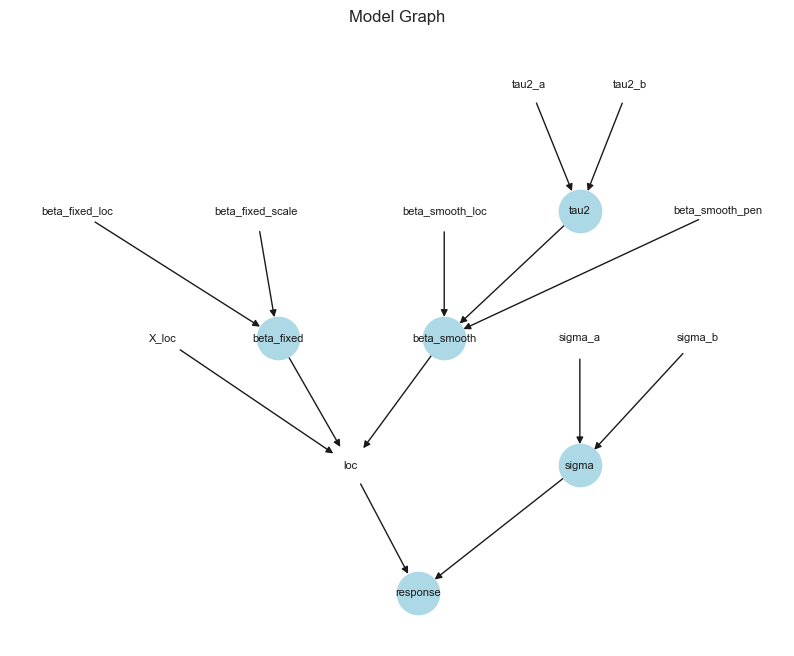

In [8]:
graph.visualize_graph()

## Inference with Bbvi

In [9]:
q = bbvi.Bbvi(graph=graph,
             model_init=True,
             loc_prec=1.0,
             scale_prec=10.0)

In [10]:
q.run_bbvi(step_size=0.05,
           threshold=1e-2,
           key_int=1,
           batch_size=q.num_obs,
           num_var_samples=10,
           chunk_size=50,
           epochs=500)

Start optimization ...
Finished optimization.


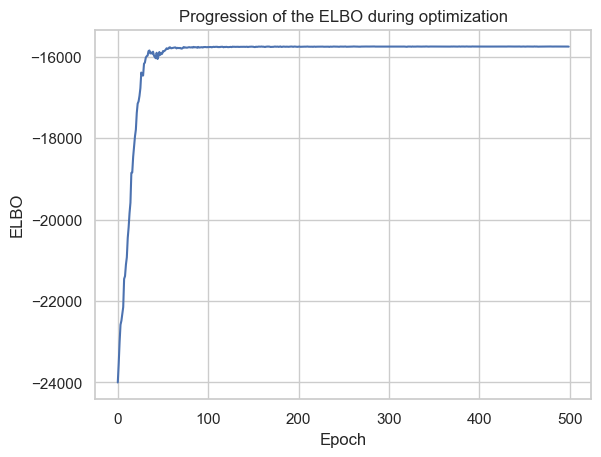

In [11]:
q.plot_elbo()

## Visualize the regression line 

In [12]:
q.return_loc_params

{'beta_fixed': {'loc': Array([18.016352], dtype=float32)},
 'tau2': {'loc': Array([0.3612671], dtype=float32)},
 'sigma': {'loc': Array([2.0798779], dtype=float32)},
 'beta_smooth': {'loc': Array([-2.5719535 , -2.6190665 , -2.1463816 , -2.257979  , -2.3865876 ,
         -2.086761  , -1.7154424 , -1.4145098 , -1.1267444 , -0.63210595,
         -0.11345977,  0.43078437,  1.1201888 ,  1.5667253 ,  2.1657693 ,
          2.8238266 ,  3.3534117 ,  3.6942184 ,  3.9351192 ], dtype=float32)}}

In [13]:
# for fixed and smooth terms
b_fixed = q.trans_var_params["beta_fixed"]["loc"]
b_smooth = q.trans_var_params["beta_smooth"]["loc"]
b = jnp.concatenate((b_fixed, b_smooth))
y = X.design_matrix @ b
sig = q.return_loc_params["sigma"]["loc"]

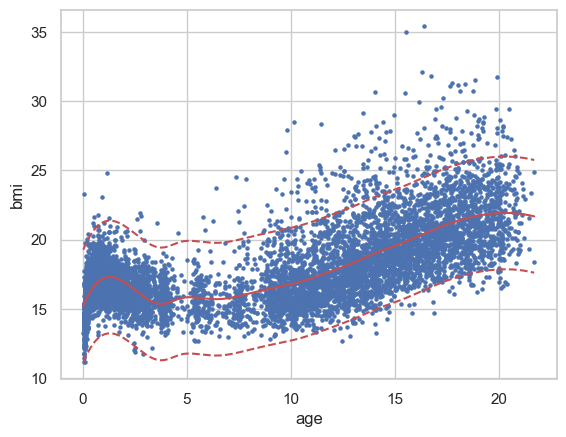

In [14]:
# plot the data
fig, ax = plt.subplots()

df.plot(kind="scatter", x="age", y="bmi", s=5, ax=ax)
ax.plot(df["age"].to_numpy(), y, color = "r")
ax.plot(df["age"].to_numpy(), y + 1.96*sig, color = "r", linestyle="--")
ax.plot(df["age"].to_numpy(), y - 1.96*sig, color = "r", linestyle="--")
plt.show()

In [15]:
tau2 = q.trans_var_params["tau2"]["loc"]
s = q.trans_var_params["tau2"]["cov"]

In [16]:
1/tau2

Array([2.7680352], dtype=float32)

### Gradient Analysis 

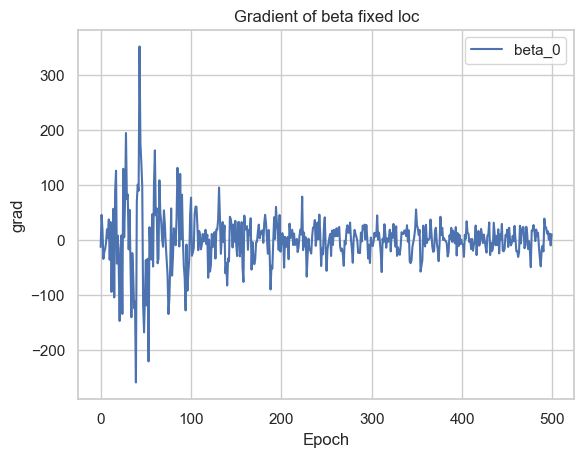

In [17]:
plot_grad_beta_fixed_loc = np.vstack([d["beta_fixed"]["loc"] for d in q.elbo_hist["grad"]])
plt.plot(q.elbo_hist["epoch"], plot_grad_beta_fixed_loc[:, 0], label="beta_0")
plt.title("Gradient of beta fixed loc")
plt.xlabel("Epoch")
plt.ylabel("grad")
plt.legend()
plt.show()

In [18]:
# Std beta_fixed loc batch_size=num_obs, var_samples=10
print(52.12418)
# Std beta_fixed loc batch_size=num_obs, var_samples=50
print(21.793095)

52.12418
21.793095


In [19]:
np.std(plot_grad_beta_fixed_loc, axis=0)

array([46.483974], dtype=float32)

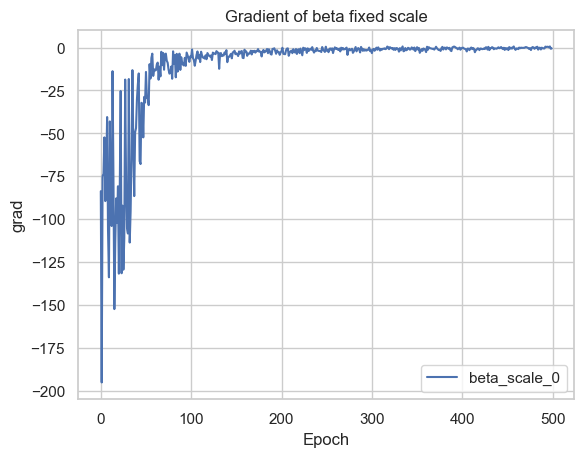

In [20]:
plot_grad_beta_fixed_scale = np.vstack([d["beta_fixed"]["log_cholesky_prec"] for d in q.elbo_hist["grad"]])
plt.plot(q.elbo_hist["epoch"], plot_grad_beta_fixed_scale[:,0], label="beta_scale_0")
plt.title("Gradient of beta fixed scale")
plt.xlabel("Epoch")
plt.ylabel("grad")
plt.legend()
plt.show()

In [21]:
# Std beta scale batch_size=num_obs, var_samples=10
print(38.95511)
# Std beta scale batch_size=num_obs, var_samples=50
print(24.391806)

38.95511
24.391806


In [22]:
np.std(plot_grad_beta_fixed_scale, axis=0)

array([25.39713], dtype=float32)

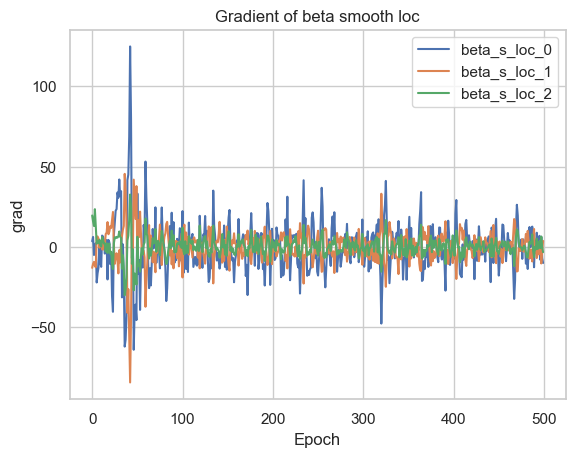

In [23]:
plot_grad_beta_smooth_loc = np.vstack([d["beta_smooth"]["loc"] for d in q.elbo_hist["grad"]])
plt.plot(q.elbo_hist["epoch"], plot_grad_beta_smooth_loc[:, 0], label="beta_s_loc_0")
plt.plot(q.elbo_hist["epoch"], plot_grad_beta_smooth_loc[:, 1], label="beta_s_loc_1")
plt.plot(q.elbo_hist["epoch"], plot_grad_beta_smooth_loc[:, 2], label="beta_s_loc_2")
plt.title("Gradient of beta smooth loc")
plt.xlabel("Epoch")
plt.ylabel("grad")
plt.legend()
plt.show()

In [24]:
# Std beta scale batch_size=num_obs, var_samples=10
print(18.398407, 11.322495, 6.748781)
# Std beta scale batch_size=num_obs, var_samples=50
print(9.385889, 5.7509966, 3.7566442)

18.398407 11.322495 6.748781
9.385889 5.7509966 3.7566442


In [25]:
np.std(plot_grad_beta_smooth_loc[:,0:3], axis=0)

array([16.459194, 10.310573,  6.125479], dtype=float32)

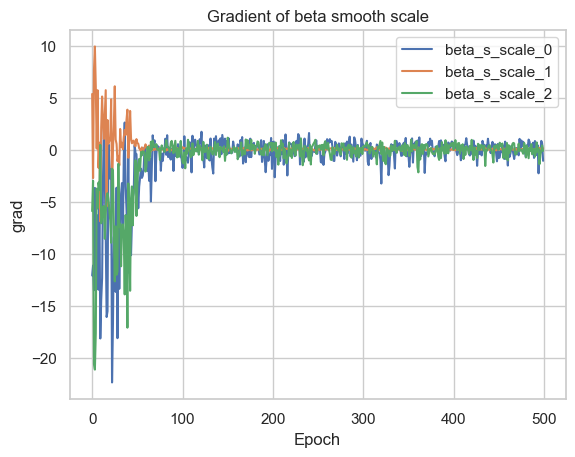

In [26]:
plot_grad_beta_smooth_scale = np.vstack([d["beta_smooth"]["log_cholesky_prec"] for d in q.elbo_hist["grad"]])
plt.plot(q.elbo_hist["epoch"], plot_grad_beta_smooth_scale[:,0], label="beta_s_scale_0")
plt.plot(q.elbo_hist["epoch"], plot_grad_beta_smooth_scale[:,1], label="beta_s_scale_1")
plt.plot(q.elbo_hist["epoch"], plot_grad_beta_smooth_scale[:,2], label="beta_s_scale_2")
plt.title("Gradient of beta smooth scale")
plt.xlabel("Epoch")
plt.ylabel("grad")
plt.legend()
plt.show()

In [27]:
# Std beta scale batch_size=num_obs, var_samples=10
print(4.478729, 2.758667, 4.6701136)
# Std beta scale batch_size=num_obs, var_samples=50
print(2.8003657, 0.83906305, 2.233884)

4.478729 2.758667 4.6701136
2.8003657 0.83906305 2.233884


In [28]:
np.std(plot_grad_beta_smooth_scale[:,0:3], axis=0)

array([3.0257897, 1.0605847, 2.6938026], dtype=float32)

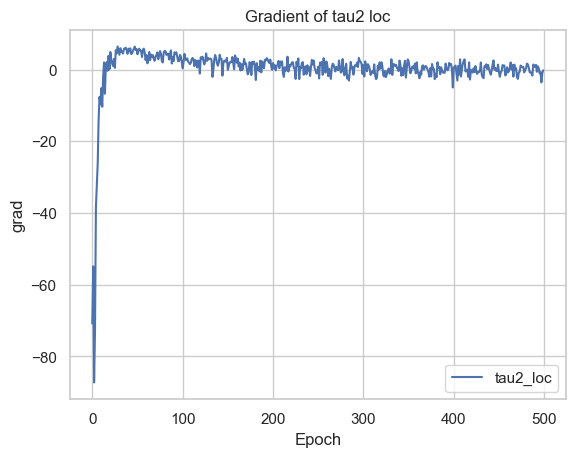

In [29]:
plot_grad_tau2_loc = np.vstack([d["tau2"]["loc"] for d in q.elbo_hist["grad"]])
plt.plot(q.elbo_hist["epoch"], plot_grad_tau2_loc[:,0], label="tau2_loc")
plt.title("Gradient of tau2 loc")
plt.xlabel("Epoch")
plt.ylabel("grad")
plt.legend()
plt.show()

In [30]:
# Std beta scale batch_size=num_obs, var_samples=10
print(7.3967853)
# Std beta scale batch_size=num_obs, var_samples=50
print(8.290854)

7.3967853
8.290854


In [31]:
np.std(plot_grad_tau2_loc[:,0], axis=0)

7.4005623

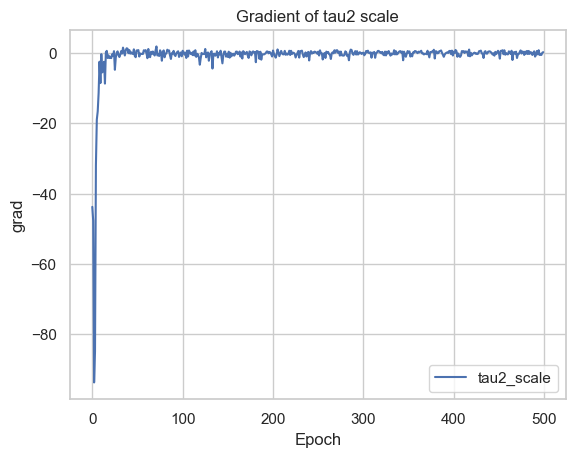

In [32]:
plot_grad_tau2_scale = np.vstack([d["tau2"]["log_cholesky_prec"] for d in q.elbo_hist["grad"]])
plt.plot(q.elbo_hist["epoch"], plot_grad_tau2_scale[:,0], label="tau2_scale")
plt.title("Gradient of tau2 scale")
plt.xlabel("Epoch")
plt.ylabel("grad")
plt.legend()
plt.show()

In [33]:
# Std beta scale batch_size=num_obs, var_samples=10
print(6.630048)
# Std beta scale batch_size=num_obs, var_samples=50
print(10.618808)

6.630048
10.618808


In [34]:
np.std(plot_grad_tau2_scale[:,0], axis=0)

6.640423

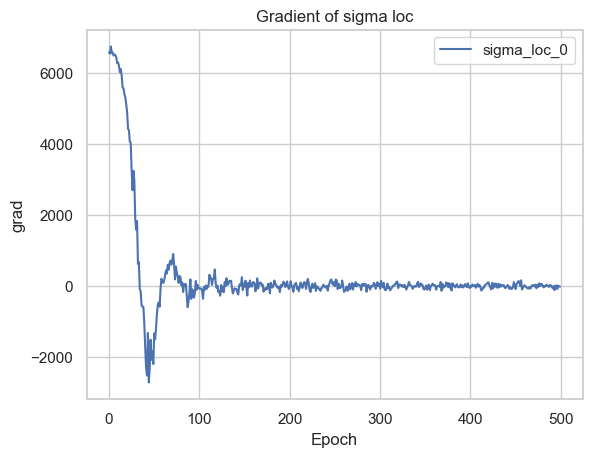

In [35]:
plot_grad_sigma_loc = np.vstack([d["sigma"]["loc"] for d in q.elbo_hist["grad"]])
plt.plot(q.elbo_hist["epoch"], plot_grad_sigma_loc[:,0], label="sigma_loc_0")
plt.title("Gradient of sigma loc")
plt.xlabel("Epoch")
plt.ylabel("grad")
plt.legend()
plt.show()

In [36]:
# Std gamma scale batch_size=num_obs, var_samples=10
print(1309.6105)
# Std gamma scale batch_size=num_obs, var_samples=50
print(1246.0782)

1309.6105
1246.0782


In [37]:
np.std(plot_grad_sigma_loc[:,0], axis=0)

1356.7126

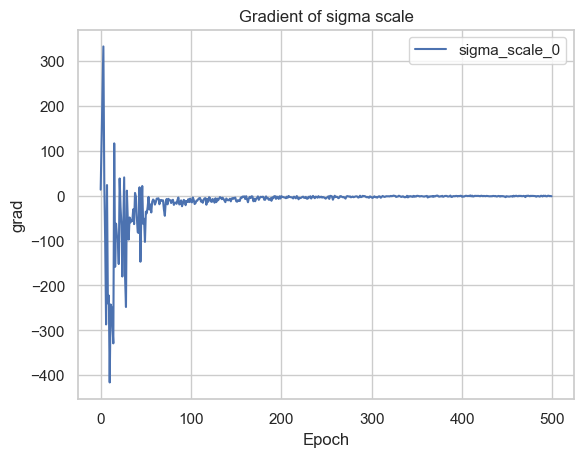

In [38]:
plot_grad_sigma_scale = np.vstack([d["sigma"]["log_cholesky_prec"] for d in q.elbo_hist["grad"]])
plt.plot(q.elbo_hist["epoch"], plot_grad_sigma_scale[:,0], label="sigma_scale_0")
plt.title("Gradient of sigma scale")
plt.xlabel("Epoch")
plt.ylabel("grad")
plt.legend()
plt.show()

In [39]:
# Std gamma scale batch_size=num_obs, var_samples=10
print(200.64609)
# Std gamma scale batch_size=num_obs, var_samples=50
print(132.5158)

200.64609
132.5158


In [40]:
np.std(plot_grad_sigma_scale[:,0], axis=0)

47.560596

In [41]:
q.cv_params

{'beta_fixed': {'cv_log_diag': Array([-0.12893088], dtype=float32),
  'cv_vec': Array([-0.01898213], dtype=float32)},
 'beta_smooth': {'cv_log_diag': Array([ 0.15825132,  0.07188509, -0.16186517, -0.09747248, -0.12905021,
         -0.07004401, -0.06634092,  0.01601373, -0.01282606,  0.08211806,
          0.03249396, -0.02170566,  0.00239666,  0.06796957,  0.08694646,
          0.11669771,  0.08200981,  0.08528001,  0.05504253], dtype=float32),
  'cv_vec': Array([-0.04374611, -0.02589876,  0.04237318, -0.00777026,  0.00174867,
          0.00158679,  0.00427647,  0.00315034,  0.00257372,  0.00785029,
          0.0215263 ,  0.00789415,  0.01176933, -0.01189796,  0.00747498,
         -0.11265463, -0.05410146, -0.01711362, -0.06840578], dtype=float32)},
 'sigma': {'cv_log_diag': Array([-0.12138027], dtype=float32),
  'cv_vec': Array([-0.04677094], dtype=float32)},
 'tau2': {'cv_log_diag': Array([-0.18946353], dtype=float32),
  'cv_vec': Array([-0.22561415], dtype=float32)}}